In [118]:
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from sklearn.metrics import (
    auc,
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from joblib import dump, load
import warnings
warnings.filterwarnings("ignore")
from IPython.display import clear_output

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import time

In [103]:
%%time
df = pd.read_excel('http://dataevents.hu/202303/filedataevents/competition_table.xlsx', engine='openpyxl')

Wall time: 2min 52s


In [104]:
df.to_csv('competition_table.csv')

In [108]:
df = df[(df.odds_home_team_win != 0) & (df.odds_draw != 0) & (df.odds_away_team_win != 0)]

In [109]:
df['home_team_relative_point_roll1_sum'] = df.home_team_point_roll1_sum - df.home_team_expected_point_roll1_sum
df['home_team_relative_point_roll2_sum'] = df.home_team_point_roll2_sum - df.home_team_expected_point_roll2_sum
df['home_team_relative_point_roll3_sum'] = df.home_team_point_roll3_sum - df.home_team_expected_point_roll3_sum
df['home_team_relative_point_roll4_sum'] = df.home_team_point_roll4_sum - df.home_team_expected_point_roll4_sum

In [110]:
df['away_team_relative_point_roll1_sum'] = df.away_team_point_roll1_sum - df.away_team_expected_point_roll1_sum
df['away_team_relative_point_roll2_sum'] = df.away_team_point_roll2_sum - df.away_team_expected_point_roll2_sum
df['away_team_relative_point_roll3_sum'] = df.away_team_point_roll3_sum - df.away_team_expected_point_roll3_sum
df['away_team_relative_point_roll4_sum'] = df.away_team_point_roll4_sum - df.away_team_expected_point_roll4_sum

In [111]:
df['prob_home_win'] = 1 / df.odds_home_team_win
df['prob_draw'] = 1 / df.odds_draw
df['prob_away_win'] = 1 / df.odds_away_team_win

In [112]:
x_variables = set(df.columns)

In [113]:
remove = set(['home_win_flag', 'draw_flag', 'away_win_flag', 'match_id', 'season'])

In [114]:
x_variables = list(x_variables - remove)

In [13]:
df_f = df.copy()

In [115]:
df = df[df.season.isin(['2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022'])]

In [116]:
df_train, df_holdout = train_test_split(df, train_size=0.8, random_state=2023)

### Setup

In [16]:
tune_grid = {
    "max_iter": [50, 100, 200],
    "max_depth": [1, 5, 10],
    "learning_rate": [0.1, 0.15, 0.2],
    "min_samples_leaf": [5, 10, 20, 30],
}

### Home Win Flag

**base prediction**

In [17]:
gbm_home = HistGradientBoostingClassifier()

In [18]:
gbm_home_cv = GridSearchCV(
    gbm_home,
    tune_grid,
    cv=5,
    scoring="roc_auc",
    verbose=10,
)

In [19]:
categorical_columns =  ['div']
numerical_columns = [col for col in x_variables if col != 'div']

In [20]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe_home = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_home_cv)], verbose=True
)

In [21]:
start = time.time()
gbm_pipe_home.fit(df_train[x_variables], df_train.home_win_flag)
stop = time.time()
clear_output()
process_time = str(round(stop - start, 0))
print(f'Process time: {process_time} seconds.')

Process time: 723.0 seconds.


In [34]:
from joblib import dump, load

In [35]:
dump(gbm_pipe_home, 'gbm_pipe_home.joblib')

['gbm_pipe_home.joblib']

In [105]:
dump(gbm_home, 'gbm_home.joblib')

['gbm_home.joblib']

In [106]:
model = load('gbm_pipe_home.joblib')

In [117]:
model.predict_proba(df_train[x_variables])

array([[0.57156995, 0.42843005],
       [0.67318311, 0.32681689],
       [0.67265765, 0.32734235],
       ...,
       [0.30865407, 0.69134593],
       [0.35285792, 0.64714208],
       [0.40165003, 0.59834997]])

In [22]:
y_pred_train = gbm_pipe_home.predict_proba(df_train[x_variables])

In [23]:
y_pred_train[0:5]

array([[0.57156995, 0.42843005],
       [0.67318311, 0.32681689],
       [0.67265765, 0.32734235],
       [0.54470678, 0.45529322],
       [0.50502935, 0.49497065]])

In [24]:
y_miss_train = y_pred_train[:,1] - np.array(df_train.home_win_flag)

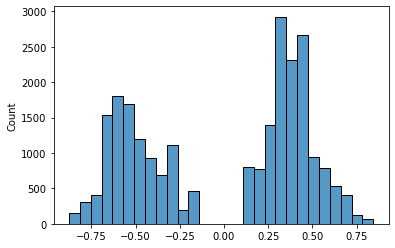

In [25]:
sns.histplot(y_miss_train);

**error correction - GBM**

In [26]:
gbm_home_error = HistGradientBoostingRegressor()

In [27]:
gbm_home_error_cv = GridSearchCV(
    gbm_home_error,
    tune_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    verbose=10,
)

In [28]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe_home_error = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_home_error_cv)], verbose=True
)

In [29]:
start = time.time()
gbm_pipe_home_error.fit(df_train[x_variables], y_miss_train)
stop = time.time()
clear_output()
process_time = str(round(stop - start, 0))
print(f'Process time: {process_time} seconds.')

Process time: 359.0 seconds.


In [30]:
y_pred_miss = gbm_pipe_home_error.predict(df_train[x_variables])

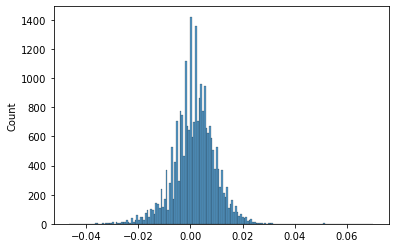

In [31]:
sns.histplot(y_pred_miss)

In [32]:
gbm_home_error_cv.best_score_

-0.21791881069822389

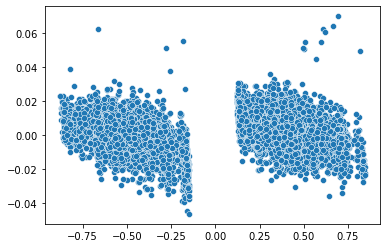

In [33]:
sns.scatterplot(x = y_miss_train, y = y_pred_miss);

**error correction - SVM**

In [48]:
from sklearn.svm import SVR

svm_home_error = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)

In [49]:
svm_home_error = SVR(kernel='linear')

In [50]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")
standard_scaler = StandardScaler()

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", standard_scaler, numerical_columns),
    ]
)

svm_pipe_home_error = Pipeline(
    [("preprocess", preprocessing), ("regressor", svm_home_error)], verbose=True
)

In [51]:
start = time.time()
svm_pipe_home_error.fit(df_train[x_variables].iloc[-6000:], y_miss_train[-6000:])
stop = time.time()
clear_output()
process_time = str(round(stop - start, 0))
print(f'Process time: {process_time} seconds.')

Process time: 82.0 seconds.


In [52]:
y_pred_miss = svm_pipe_home_error.predict(df_train[x_variables])

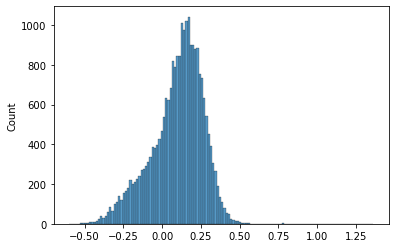

In [53]:
sns.histplot(y_pred_miss)

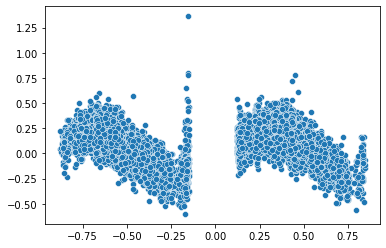

In [54]:
sns.scatterplot(x = y_miss_train, y = y_pred_miss);

**k-means clustering of observations**

In [86]:
%%time
kmeans_home_win = KMeans(n_clusters=2, random_state=2023, n_init=10)

Wall time: 0 ns


In [87]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

kmeans_pipe_home = Pipeline(
    [("preprocess", preprocessing), ("clustering", kmeans_home_win)], verbose=True
)

In [72]:
kmeans_variables = list(set(x_variables) - set(['div']))

In [73]:
kmeans_variables

['home_team_opponents_shot_on_target_roll2_sum',
 'home_team_point_roll1_sum',
 'odds_away_team_defeat_roll4_mean',
 'away_team_red_card_roll1_sum',
 'away_team_expected_point_roll2_sum',
 'away_team_shot_roll3_sum',
 'home_team_opponents_goal_roll3_sum',
 'away_team_point_roll3_sum',
 'home_team_corner_roll3_sum',
 'home_team_yellow_card_roll4_sum',
 'home_team_opponents_yellow_card_roll3_sum',
 'away_team_shot_on_target_roll3_sum',
 'odds_away_team_win_roll4_mean',
 'odds_away_team_draw_roll2_mean',
 'away_team_fault_roll3_sum',
 'prob_draw',
 'away_team_shot_roll1_sum',
 'prob_away_win',
 'away_team_opponents_goal_roll3_sum',
 'odds_home_team_draw_roll3_mean',
 'odds_home_team_win_roll3_mean',
 'home_team_shot_on_target_roll4_sum',
 'home_team_yellow_card_roll1_sum',
 'odds_home_team_win_roll1_mean',
 'home_team_opponents_corner_roll2_sum',
 'home_team_opponents_corner_roll1_sum',
 'away_team_red_card_roll2_sum',
 'home_team_opponents_shot_on_target_roll3_sum',
 'away_team_goal_roll

In [88]:
%%time
kmeans_pipe_home.fit(df_train[x_variables])

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[Pipeline] ........ (step 2 of 2) Processing clustering, total=   2.0s
Wall time: 2.13 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['div']),
                                                 ('num', 'passthrough',
                                                  ['home_team_opponents_shot_on_target_roll2_sum',
                                                   'home_team_point_roll1_sum',
                                                   'away_team_red_card_roll1_sum',
                                                   'odds_away_team_defeat_roll4_mean',
                                                   'away_team_shot_roll3_sum',
                                                   'away_team_expected_point_roll2_sum',
                                                   'home_...
                                                   'home_team_yellow_card_roll1_sum',
                          

In [89]:
y_cluster_labels = kmeans_pipe_home.predict(df_train[x_variables])

In [96]:
df_predict_train = pd.DataFrame({'y_miss_train': y_miss_train, 
                                 'y_cluster_labels': y_cluster_labels})

In [97]:
df_predict_train.head()

,y_miss_train,y_cluster_labels
0,0.428430,0
1,0.326817,1
2,0.327342,1
3,0.455293,1
4,0.494971,0


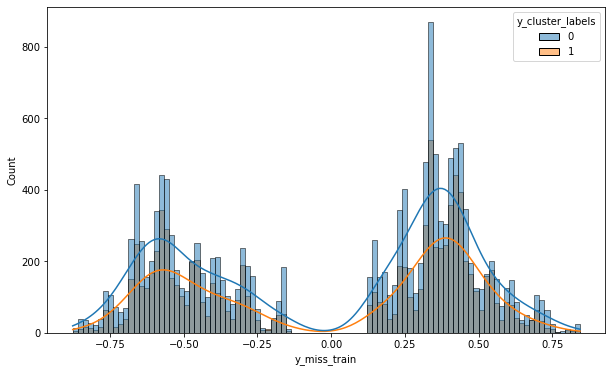

In [100]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(ax = ax, 
             data = df_predict_train, 
             x = 'y_miss_train', 
             hue = 'y_cluster_labels', kde = True, 
             bins = 100);

In [92]:
y_cluster_labels.sum()

9365

In [93]:
y_miss_train.shape

(24172,)